<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Implementing-MLPs-with-Keras" data-toc-modified-id="Implementing-MLPs-with-Keras-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Implementing MLPs with Keras</a></span><ul class="toc-item"><li><span><a href="#Building-A--Regression-MLP-Using-the-Sequential-API" data-toc-modified-id="Building-A--Regression-MLP-Using-the-Sequential-API-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Building A  Regression MLP Using the Sequential API</a></span></li><li><span><a href="#Building-Complex-models-Using-the-Functional-API" data-toc-modified-id="Building-Complex-models-Using-the-Functional-API-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Building Complex models Using the Functional API</a></span></li><li><span><a href="#Using-the-Subclassing-API-to-Build-Dunamic-Models" data-toc-modified-id="Using-the-Subclassing-API-to-Build-Dunamic-Models-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Using the Subclassing API to Build Dunamic Models</a></span></li><li><span><a href="#Saving-and-Restoring-a-Model" data-toc-modified-id="Saving-and-Restoring-a-Model-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Saving and Restoring a Model</a></span></li><li><span><a href="#Using-Callbacks" data-toc-modified-id="Using-Callbacks-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Using Callbacks</a></span></li><li><span><a href="#Using-TensorBoard-for-Visualization" data-toc-modified-id="Using-TensorBoard-for-Visualization-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Using TensorBoard for Visualization</a></span></li></ul></li></ul></div>

## Implementing MLPs with Keras

### Building A  Regression MLP Using the Sequential API

In [183]:
import tensorflow as tf
from tensorflow import keras

In [123]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
housing = fetch_california_housing()

In [14]:
X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full)

In [16]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [21]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation='relu', input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])

In [23]:
model.compile(optimizer='sgd', loss='mean_squared_error')

In [40]:
history = model.fit(X_train, y_train, batch_size=64, epochs=20, validation_data=(X_valid, y_valid), verbose=0)

In [41]:
mse_test = model.evaluate(X_test, y_test)

162/162 [==============================] - 0s 756us/step - loss: 0.3481


In [42]:
X_new = X_test[:3]
y_pred = model.predict(X_new)

### Building Complex models Using the Functional API

In [50]:
input_ = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation='relu')(input_)
hidden2 = keras.layers.Dense(30, activation='relu')(hidden1)
concat = keras.layers.Concatenate()([input_, hidden2])
output = keras.layers.Dense(1)(concat)
model = keras.Model(inputs=[input_], outputs=[output])

In [53]:
model.compile(loss='mse', optimizer='sgd')

In [59]:
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=20, verbose=0)

In [68]:
model.evaluate(X_test, y_test)

162/162 [==============================] - 0s 732us/step - loss: 0.3078


0.3077518939971924

More complex model with auxiliary output

In [72]:
X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]

In [75]:
input_A = keras.layers.Input(shape=(5,), name='wide_input')
input_B = keras.layers.Input(shape=(6,), name='deep_input')
hidden1 = keras.layers.Dense(30, activation='relu')(input_B)
hidden2 = keras.layers.Dense(30, activation='relu')(hidden1)
concat = keras.layers.Concatenate()([hidden2, input_A])
output = keras.layers.Dense(1, name='output')(concat)
aux_output = keras.layers.Dense(1, name='aux_output')(hidden2)
model = keras.Model(inputs=[input_A, input_B], outputs=[output, aux_output])

In [76]:
model.compile(optimizer='sgd', loss='mse')

In [81]:
model.fit(x=[X_train_A, X_train_B], y=[y_train, y_train], epochs=20, validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid]), verbose=0)

In [82]:
model.evaluate([X_test_A, X_test_B], [y_test, y_test])

162/162 [==============================] - 0s 748us/step - loss: 0.7078 - output_loss: 0.3225 - aux_output_loss: 0.3853


[0.707812488079071, 0.3225070834159851, 0.38530558347702026]

### Using the Subclassing API to Build Dunamic Models

In [112]:
class WideAndDeepModel(keras.Model):
    def __init__(self, units=30, activation='relu', **kwargs):
        super(WideAndDeepModel, self).__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(units, activation=activation)
        self.hidden2 = keras.layers.Dense(units, activation=activation)
        self.concat = keras.layers.Concatenate()
        self.main_output = keras.layers.Dense(1)
        self.aux_output = keras.layers.Dense(1)
        
    def call(self, inputs):
        input_A, input_B = inputs
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(hidden1)
        concat = self.concat([input_A, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return main_output, aux_output

In [113]:
model = WideAndDeepModel()

In [114]:
model.compile(optimizer='sgd', loss='mse')

In [119]:
history = model.fit(x=[X_train_A, X_train_B], y=[y_train, y_train], epochs=20, validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid]), verbose=0)

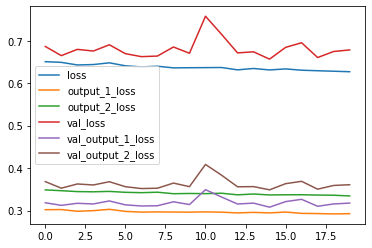

In [126]:
pd.DataFrame(history.history).plot()

### Saving and Restoring a Model

In [129]:
model.save("my_keras_model", save_format='tf')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: my_keras_model/assets


In [135]:
model = keras.models.load_model("my_keras_model/")

### Using Callbacks

In [142]:
checkpoints_cb = keras.callbacks.ModelCheckpoint("my_keras_model/", save_best_only=True)

In [143]:
history = model.fit(x=[X_train_A, X_train_B], y=[y_train, y_train], epochs=1, validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid]), verbose=1, callbacks=[checkpoints_cb])

363/363 [==============================] - 1s 2ms/step - loss: 0.6212 - output_1_loss: 0.2904 - output_2_loss: 0.3309 - val_loss: 0.7002 - val_output_1_loss: 0.3268 - val_output_2_loss: 0.3734


In [144]:
model = keras.models.load_model('my_keras_model/')

In [148]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [150]:
history = model.fit(x=[X_train_A, X_train_B], y=[y_train, y_train], epochs=20, validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid]), verbose=0, callbacks=[early_stopping_cb])

Customized callback

Call by fit()
- on_train_begin()
- on_train_end()
- on_epoch_begin()
- on_epoch_end()
- on_batch_begin()
- on_batch_end()

Call by evaluate()
- on_test_begin()
- on_test_end()
- on_test_batch_begin()
- on_test_batch_end()

Call by predict()
- on_predict_begin()
- on_predict_end()
- on_predict_batch_begin()
- on_predict_batch_end()

In [156]:
class PrintValTrainRatioCallBack(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print('\nval/train {:.2f}'.format(logs['val_loss']/logs['loss']))

In [158]:
history = model.fit(x=[X_train_A, X_train_B], y=[y_train, y_train], epochs=1, validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid]), verbose=0, callbacks=[PrintValTrainRatioCallBack()])


val/train 1.11


### Using TensorBoard for Visualization

In [159]:
import os

In [164]:
root_logdir = os.path.join(os.curdir, "my_logs")

In [165]:
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d_%H_%M_%S")
    return os.path.join(root_logdir, run_id)

In [176]:
run_logdir = get_run_logdir()

In [178]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [180]:
history = model.fit(x=[X_train_A, X_train_B], y=[y_train, y_train], epochs=30, validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid]), verbose=0, callbacks=[tensorboard_cb])

Create a SummaryWriter

In [181]:
test_logidr = get_run_logdir()

In [184]:
writer = tf.summary.create_file_writer(test_logidr)

In [188]:
with writer.as_default():
    # mock model training iterations
    for step in range(1, 1000+1):
        # scalar summary
        tf.summary.scalar("my_scalar", np.sin(step/10), step=step)

        # histogram summary
        data = (np.random.randn(100)+2) * step/100
        tf.summary.histogram("my_hist", data, buckets=50, step=step)
        
        # image summary
        images = np.random.randn(2, 32, 32, 3) # two images
        tf.summary.image("my_image", images*step/1000, step=step)
        
        # text summary
        text = [f"The step is {step}"]
        tf.summary.text("my_text", text, step=step)
        
        # audio summary
        sine_wave = tf.math.sin(tf.range(12000)/ 48000 * 2 * np.pi * step)
        audio = tf.reshape(tf.cast(sine_wave, tf.float32), [1, -1, 1])
        tf.summary.audio("my_audio", audio, sample_rate=480000, step=step)